<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

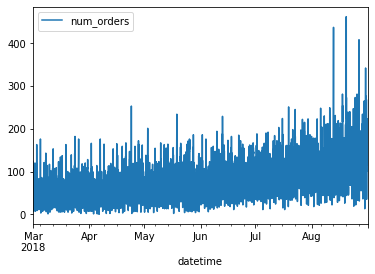

In [3]:
data = data.resample('1H').sum()
data.plot()

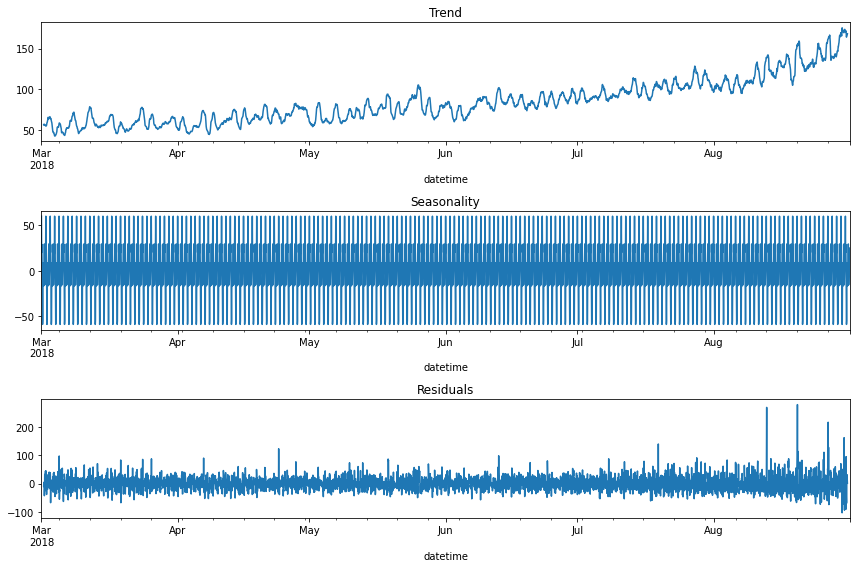

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

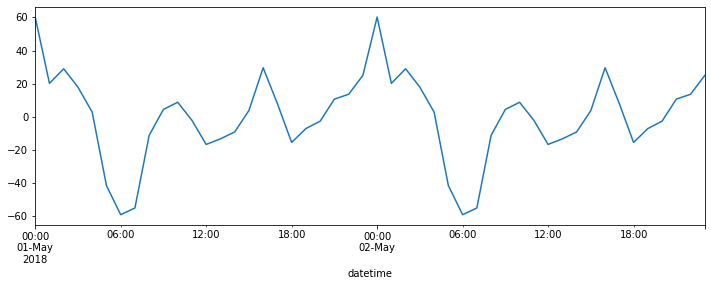

In [5]:
dates = decomposed.seasonal['2018-05-01':'2018-05-2']
plt.figure(figsize=(12, 4))
dates.plot()

**Вывод** в июле и августе количество заказов такси постепенно увеличивается. Выделена сезонность за день, в 6 утра заказов становится меньше, а в полночь пик заказов.

## Анализ

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
make_features(data, 24, 24)

In [8]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train1, valid = train_test_split(train, shuffle=False, test_size=0.1)
train = train.dropna()
train1 = train1.dropna()

In [9]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_train1 = train1.drop('num_orders', axis=1)
target_train1 = train1['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение

### LinearRegression

In [10]:
model = LinearRegression().fit(features_train1, target_train1)

pred_train = model.predict(features_train1)
pred_valid = model.predict(features_valid)

print("RMSE обучающей выборки:", sqrt(mean_squared_error(target_train1, pred_train)))
print("RMSE валидационной выборки: ", sqrt(mean_squared_error(target_valid, pred_valid)))

RMSE обучающей выборки: 24.733648024981655

RMSE валидационной выборки:  34.136280205461254


### DecisionTreeRegressor

In [11]:
min_sc = 48

for dept in range(1, 22, 5):
    model = DecisionTreeRegressor(max_depth=dept).fit(features_train1, target_train1)
    
    score = sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
        
    if score < min_sc:
        min_sc = score
        best_model = model

pred_train = model.predict(features_train1)
pred_valid = model.predict(features_valid)

print("RMSE обучающей выборки:", sqrt(mean_squared_error(target_train1, pred_train)))
print("RMSE валидационной выборки: ", sqrt(mean_squared_error(target_valid, pred_valid)))

RMSE обучающей выборки: 1.0858134905143846

RMSE валидационной выборки:  46.53768595587463


### RandomForestRegressor

In [12]:
min_sc = 48

for dept in range(5, 21, 5):
    for nest in range(10, 100, 20):
        model = RandomForestRegressor(n_estimators=nest, max_depth=dept, random_state=12345).fit(features_train1, target_train1)

        score = sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
        
        if score < min_sc:
            min_sc = score
            best_model1 = model
        
pred_train = model.predict(features_train1)
pred_valid = model.predict(features_valid)

print("RMSE обучающей выборки:", sqrt(mean_squared_error(target_train1, pred_train)))
print("RMSE валидационной выборки: ", sqrt(mean_squared_error(target_valid, pred_valid)))

RMSE обучающей выборки: 8.36349002189449

RMSE валидационной выборки:  33.310543711863545


## Тестирование

In [13]:
best_model1.fit(features_train, target_train)
pred_test = best_model1.predict(features_test)
print("RMSE тестовой выборки:", sqrt(mean_squared_error(target_test, pred_test)))

RMSE тестовой выборки: 44.21915149531916


**Вывод** были загружены данные временного ряда, выделены признаки и разделены на обучающую, валидационную и тестовую выборку. Обучены несколько моделей и осуществлен перебор гиперпараметров. Лучшей была определена модель случайного леса, для нееосуществлено финально тестирование.

<AxesSubplot:xlabel='datetime'>

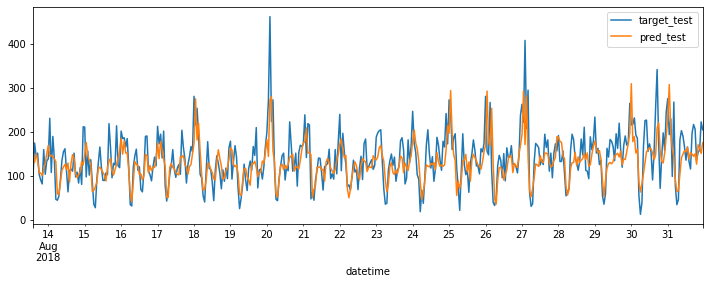

In [14]:
res = pd.DataFrame(index=target_test.index)

res['target_test'] = target_test
res['pred_test'] = pred_test

res.plot(figsize=(12, 4))